In [1]:
import pyvisa as visa
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import scipy
import os
import sys
#rm = visa.ResourceManager()
#print(rm.list_resources())

In [2]:
'''
Use the output from the above cell to rename the resources as necessary. The query commands ensure the keithleys
are online and listening
'''

Keithley = rm.open_resource('GPIB0::25::INSTR')
Keithleygate = rm.open_resource('GPIB0::26::INSTR')
print(Keithley.query('*IDN?'))
print(Keithleygate.query('*IDN?'))

KEITHLEY INSTRUMENTS INC.,MODEL 2400,1197267,C33   Mar 31 2015 09:32:39/A02  /K/J

KEITHLEY INSTRUMENTS INC.,MODEL 2400,4302829,C33   Mar 31 2015 09:32:39/A02  /V/M



Conductance: 1.8761525768496853e-10 Siemens


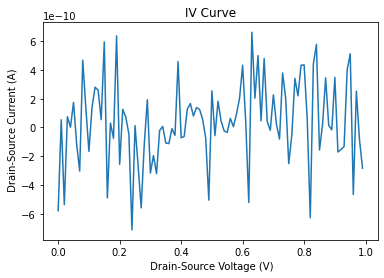

100


In [4]:
%run KeithleyIVSweep.py 0 1 0.01 test.txt gate

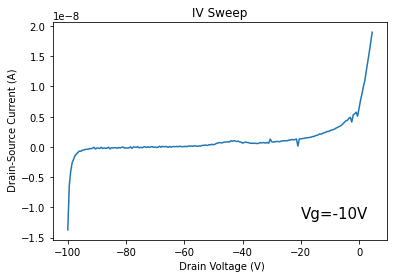

In [31]:
%run KeithleyIVSweepFixedGate.py -100 5 0.5 -10 P2_1_IdVd_min10_1_up.txt up

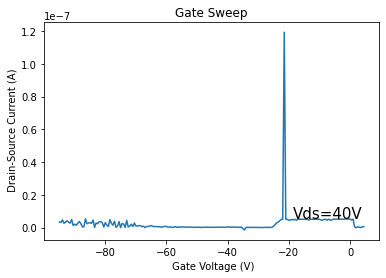

In [13]:
%run KeithleyGateSweepFixedDrain.py -95 5 0.5 40 test.txt down

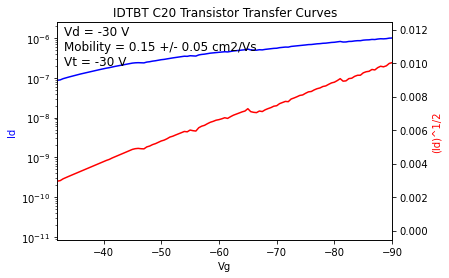

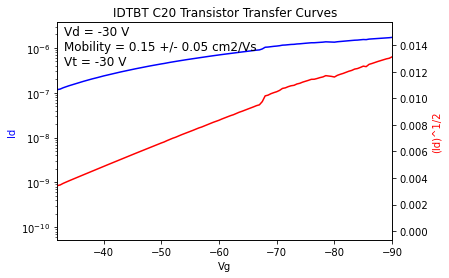

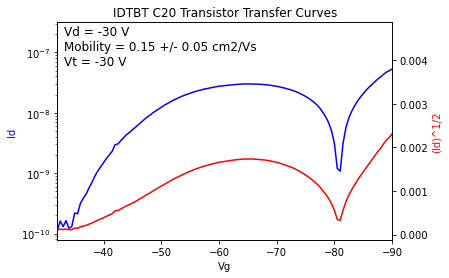

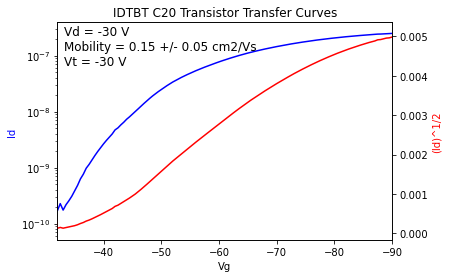

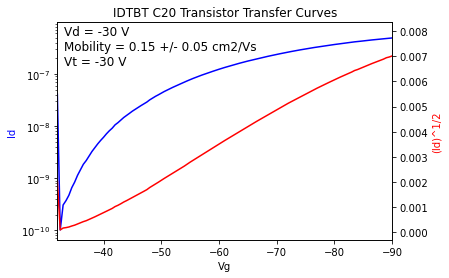

In [60]:
material = "P2"
curve= "IdVg"
for filename in os.listdir(os.getcwd() + '/data'):
    if material in filename:
        if curve in filename:
            fig,ax = plt.subplots()
            result = np.loadtxt(os.getcwd()+ '/data/' + filename)
            xval = result[0]-10
            yval = np.absolute(result[1])
            yval1 = np.sqrt(yval)*10
            ax.plot(xval,yval, color = 'b')
            ax.set_xlabel('Vg')
            ax.set_ylabel('Id', color = 'b')
            plt.yscale('log')
            
            ax2 = ax.twinx()
            ax2.plot(xval,yval1, color = 'r')
            ax2.set_ylabel('(Id)^1/2', color = 'r')
            
            #plt.title(filename)
            plt.title('IDTBT C20 Transistor Transfer Curves')
            plt.xlim(-32,-90)
        
            plt.figtext(0.14,0.73,"Vd = -30 V \n"  'Mobility = 0.15 +/- 0.05 cm2/Vs \n' 'Vt = -30 V', fontsize=12)
            

In [ ]:
for filename in os.listdir(os.getcwd() + '/data'):
    if material in filename:
        if curve in filename:
            plt.figure()
            result = np.loadtxt(os.getcwd()+ '/data/' + filename)
            xval = result[0]
            yval = np.absolute(result[1])
            plt.plot(xval,yval)
            plt.title(filename)
            plt.xlim(-30,-80)
            #plt.yscale('log')

In [3]:
def plotter(filename, bot = 0 , top = 0, label = 'none'):
    result = np.loadtxt(os.getcwd()+ '/data/' + filename)
    xval = result[0]
    yval = result[1]
    if bot == 0 and top == 0:
        plt.plot(xval,yval)
    else:
        mini = np.where(xval == bot)[0][0]
        maxi = np.where(xval == top)[0][0]
        if mini < maxi:
            xvalues = xval[mini:maxi]
            yvalues = yval[mini:maxi]
        else:
            xvalues = xval[maxi:mini]
            yvalues = yval[maxi:mini]
            
        f = scipy.interpolate.interp1d(xval, yval, kind = 'nearest')
        xnew = np.linspace(min(xvalues), max(xvalues), num=20, endpoint=True)
        ynew = f(xnew)
            
        plt.plot(xnew,ynew, label = label)

Text(0.5, 1.0, 'P2 Transfer Characteristics')

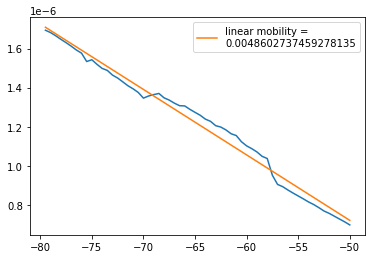

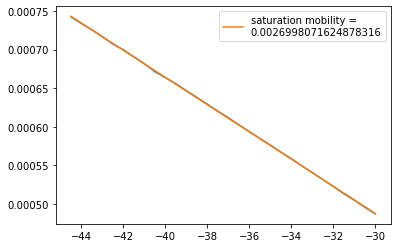

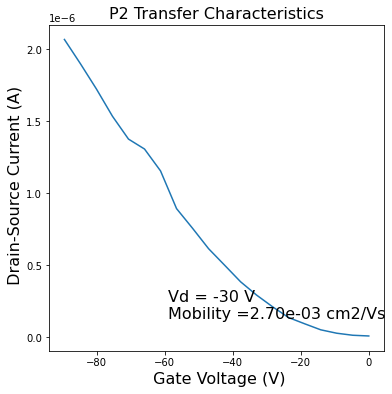

In [4]:
# use the above file names and plots to select a curve, and change start and stop positions to calculate linear mobility
filename = 'P2_IdVg_Vd20.txt'
result = np.loadtxt(os.getcwd()+ '/data/' + filename)
xval = result[0]
yval = result[1]

#input here parameters to calculate the mobility
L = 50        #50 micron channel length
W = 1000      #1000 micron channel width
Ci = 11.5e-9    #10 nF/cm^2 equation: permitivity of dielectric(sio2)*oxide layer thickness in cm (300nm)
Vd = 30     # Volt drain voltage

#input here the start and stop position of the region of interest for linear mobility
startpos = -80
stoppos = -50
mini = np.where(xval == startpos)[0][0]
maxi = np.where(xval == stoppos)[0][0]
if mini < maxi:
    xvalues = xval[mini:maxi]
    yvalues = yval[mini:maxi]
else:
    xvalues = xval[maxi:mini]
    yvalues = yval[maxi:mini]
slope, intercept, r_value, p_value, std_error = stats.linregress(xvalues, yvalues)
yregress = slope*xvalues+intercept
mu_lin = (abs(slope)*L)/(W*Vd*Ci)
plt.figure()
plt.plot(xvalues,yvalues)
plt.plot(xvalues,yregress, label = "linear mobility = \n" + str(mu_lin) )
plt.legend()

#input here the start and stop position of the region of interest for saturation mobility
startpos = -45
stoppos = -30
mini = np.where(xval == startpos)[0][0]
maxi = np.where(xval == stoppos)[0][0]
if mini < maxi:
    xvalues = xval[mini:maxi]
    yvalues = np.sqrt(abs(yval[mini:maxi]))
else:
    xvalues = xval[maxi:mini]
    yvalues = np.sqrt(abs(yval[maxi:mini]))
slope, intercept, r_value, p_value, std_error = stats.linregress(xvalues, yvalues)
mu_sat = (2*L)/(W*Ci)*(slope)**2
yregress = slope*xvalues+intercept
plt.figure()
plt.plot(xvalues,yvalues)
plt.plot(xvalues,yregress, label = "saturation mobility = \n" + str(mu_sat))
plt.legend()


plt.figure(figsize=(6,6))
plotter(filename, -90, 0)
filename = 'P2 Transfer Characteristics'
plt.figtext(0.4,0.2,"Vd = -30 V \n"  'Mobility =' + "{:.2e}".format(mu_sat) + " cm2/Vs", fontsize=16)
plt.xlabel(' Gate Voltage (V)',fontsize=16)
plt.ylabel(' Drain-Source Current (A)',fontsize=16)
plt.title(filename,fontsize=16)
#plt.savefig(os.getcwd() + '/figures/' + filename, dpi=300, bbox_inches='tight')

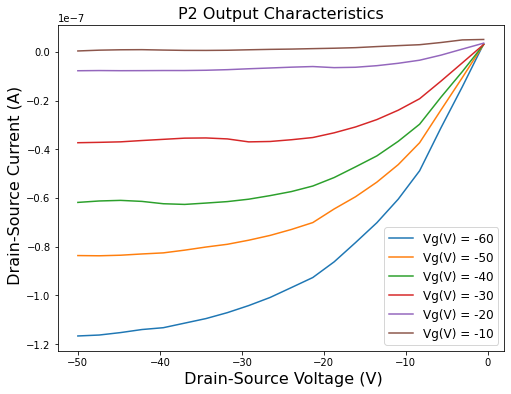

In [119]:
# visualization of output characteristic curves!   
filename = "P2 Output Characteristics"
plt.figure(figsize=(8,6))
plotter('P2_1_IdVd_min60_1_up.txt', -50, 0, "Vg(V) = -60")
plotter('P2_1_IdVd_min50_1_up.txt', -50, 0, "Vg(V) = -50")
plotter('P2_1_IdVd_min40_1_up.txt', -50, 0, "Vg(V) = -40")
plotter('P2_1_IdVd_min30_1_up.txt', -50, 0, "Vg(V) = -30")
plotter('P2_1_IdVd_min20_1_up.txt', -50, 0, "Vg(V) = -20")
plotter('P2_1_IdVd_min10_1_up.txt', -50, 0, "Vg(V) = -10")
plt.xlabel(' Drain-Source Voltage (V)',fontsize=16)
plt.ylabel(' Drain-Source Current (A)',fontsize=16)
plt.legend(fontsize=12,title=None, title_fontsize=12)
plt.title(filename,fontsize=16)
plt.savefig(os.getcwd() + '/figures/' + filename, dpi=300, bbox_inches='tight')